In [1]:

import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from anytree import RenderTree
from lib.tree_functions import import_tree_from_json
from lib.config import pipeline_name, db_name, tree_json_path
import tempfile
from lib import count_plot
import networkx as nx

base_url = "https://cdl-segg.fra1.cdn.digitaloceanspaces.com/cdl-segg/"

### Download Section Tree

In [2]:
tree_url = base_url + tree_json_path
response = requests.get(tree_url)
response.raise_for_status()
with tempfile.NamedTemporaryFile(delete=False, suffix=".json") as temp_file:
    temp_file.write(response.content)
    path = temp_file.name
    root_node = import_tree_from_json(path)

for pre, fill, node in RenderTree(root_node):
    print(f"{pre}{node.name} ({node.data_id})")

Pimp my School Downloads (36)
├── 1.1. Was ist Schülervertretungsarbeit (38)
├── 1.2. Rechtliche Grundlagen (39)
│   ├── Mecklenburg-Vorpommern (41)
│   ├── Besonderheiten an einzelnen Schulformen (42)
│   │   ├── Oberstufenzentren (OSZ) (159)
│   │   └── Grundschulen (173)
│   ├── Nordrhein-Westfalen (52)
│   │   └── Erlasse (55)
│   ├── Sachsen-Anhalt (53)
│   ├── Berlin (56)
│   │   ├── Besonderheiten Berufsschulen (57)
│   │   ├── Formales für Gremien (58)
│   │   └── Schülervertretung in Bezirk und Land (59)
│   ├── Hessen (132)
│   └── Brandenburg (153)
├── 1.3. Mögliche Aktionen, Themen und Projekte von A-Z (46)
│   ├── Unterricht verändern (47)
│   ├── Projektideensammlungen zur Inspiration (111)
│   ├── Aktionen und Projekte (Beschreibungen) (51)
│   │   ├── Lesenacht (105)
│   │   ├── Party (106)
│   │   ├── Schulball (107)
│   │   ├── Schülernachhilfe-Pool (108)
│   │   ├── Valentinstag (109)
│   │   ├── Schülerfirma (160)
│   │   └── Veranstaltungen (110)
│   └── Klima

### Download Files

In [3]:
posts_url = base_url + "downloads.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

data_id,data_category_id,title,category_title,download_link,file_type
i64,i64,str,str,str,str
3888,81,"""SV-Tipps Broschüre_2004 (DGB)""","""Handbücher""","""https://meinsvwissen.de/downlo…","""pdf"""
4297,126,"""Anleitung - Open Space""","""Open Space, Barcamp, Zukunftsw…","""https://meinsvwissen.de/downlo…","""pdf"""
4201,118,"""Monatsbericht""","""SV-Newsletter""","""https://meinsvwissen.de/downlo…","""pdf"""
3897,86,"""Wahl-und-Geschäftsordnung""","""Arbeitshilfen für Bezirksschu…","""https://meinsvwissen.de/downlo…","""pdf"""
3924,83,"""LSV Positionen""","""NRW""","""https://meinsvwissen.de/downlo…","""pdf"""


In [4]:
df["file_type"].value_counts().sort("count", descending=True)

file_type,count
str,u32
"""pdf""",406
"""octet-stream""",102
"""png""",27
"""mp4""",17
"""jpeg""",13


### Posts

In [5]:
posts_url = base_url + "posts.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

id,date,title,stage,tool_types,topics,download_chapter_dedicated,download_chapters_further,book_chapter,related_posts
i64,date,str,str,list[cat],list[str],i64,list[i64],str,list[i64]
5656,2022-05-03,"""Wegweiser: Wie kann ich andere…","""sv-alltag""","[""infografik""]","[""mehr-werden"", ""motivation""]",null,[65],"""https://meinsvwissen.de/wp-con…","[5237, 4593, … 5276]"
4909,2022-03-20,"""SV Fahrten organisieren""","""profis""","[""video""]","[""ideenfindung"", ""motivation"", ""projektarbeit""]",null,[76],"""https://meinsvwissen.de/wp-con…","[4863, 5154, 4791]"
7290,2024-08-24,"""Mappe für gewählte Klassenspre…","""grundlagen""","[""methode"", ""vorlage""]","[""gremien"", ""klassensprecher"", … ""wahlen""]",154,[],null,"[5764, 7401, … 4801]"
5281,2022-02-07,"""Checkliste SV Wissen weitergeb…","""sv-alltag""","[""download""]","[""einarbeitung""]",null,[74],null,"[4801, 7700]"
6182,2022-10-03,"""Test: wichtige Kontakte in der…","""fortgeschrittene""","[""selbsttest""]","[""antraege"", ""gremien"", … ""rechte""]",null,[],null,"[6454, 4983, 6588]"


In [6]:
len(df)

88

In [7]:
df["stage"].value_counts().sort("count", descending=True)

stage,count
str,u32
"""sv-alltag""",31
"""grundlagen""",30
"""fortgeschrittene""",13
"""profis""",9
null,5


In [8]:
df["stage"].unique().to_list()

[None, 'profis', 'fortgeschrittene', 'grundlagen', 'sv-alltag']

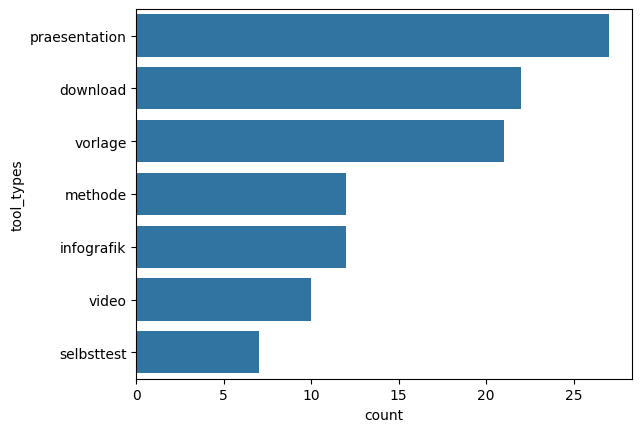

In [9]:
count_plot(df, "tool_types")

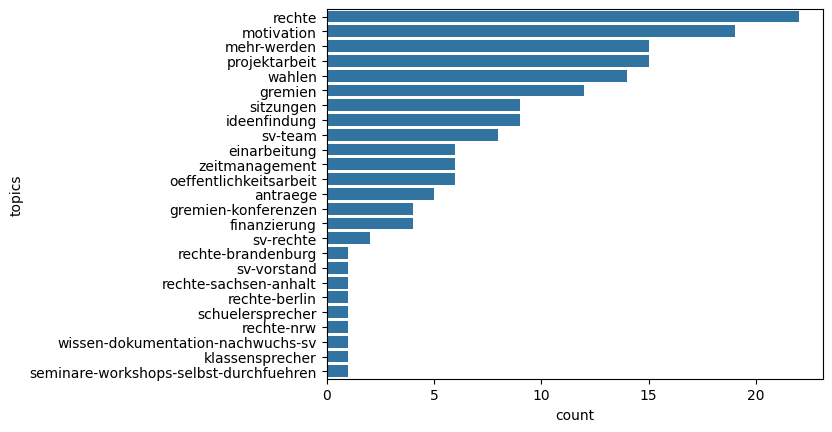

In [10]:
count_plot(df, "topics")

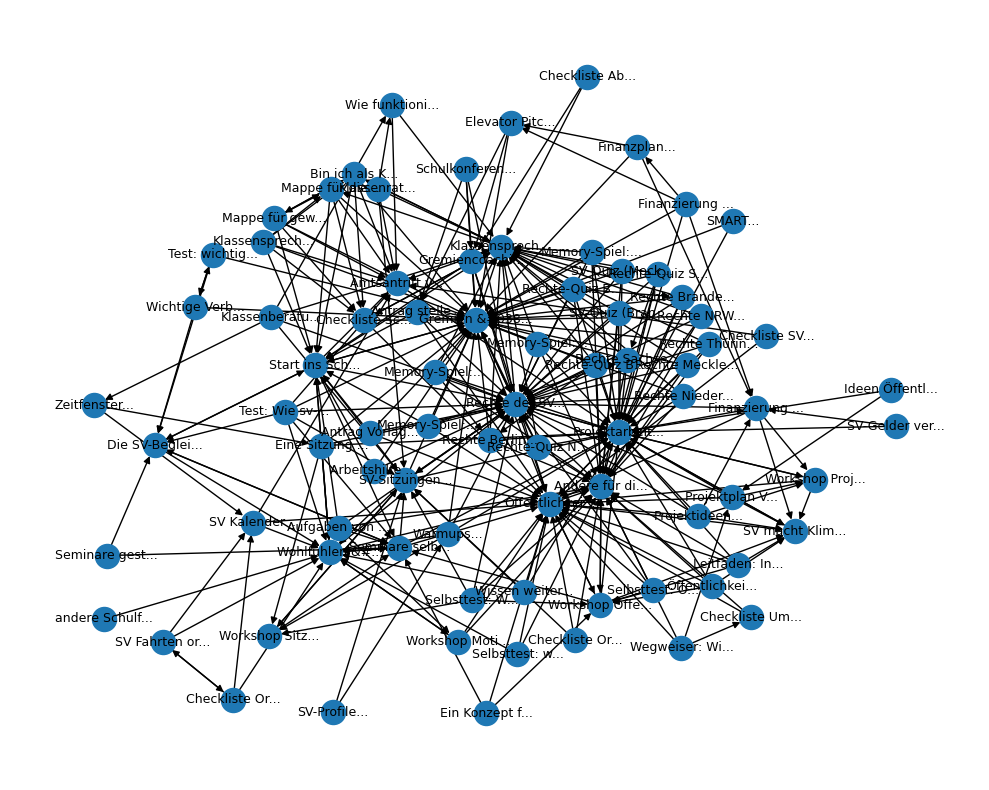

In [11]:
records = df.to_dicts()

G = nx.DiGraph()
for rec in records:
    src = rec["id"]
    G.add_node(src, label=f"{rec['title'][:13]}...")
    for tgt in rec.get("related_posts") or []:
        G.add_edge(src, tgt)

nodes_to_remove = [n for n, d in G.degree() if d <= 1]
G.remove_nodes_from(nodes_to_remove)

pos = nx.nx_agraph.graphviz_layout(G, prog="neato")

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(
    G,
    pos,
)
nx.draw_networkx_edges(
    G,
    pos,
)
labels = nx.get_node_attributes(G, "label")
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_family="sans-serif")

plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
self_loop_nodes = [n for n in G.nodes() if G.has_edge(n, n)]

# 2. Or via self-loop edges
self_loop_nodes = list({u for u, v in nx.selfloop_edges(G)})

print("Node IDs with self-loops:", self_loop_nodes)


Node IDs with self-loops: []


### Sections

In [13]:
posts_url = base_url + "sections.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

post_id,title,text,type,external_link,transcript_url
i64,str,str,cat,str,str
4909,null,"""Eine regelmäßig stattfindende …","""plain_text""",null,null
4909,null,null,"""youtube""","""https://www.youtube.com/watch?…",null
7290,null,"""Die Idee: zu Beginn des Schulj…","""plain_text""",null,null
7290,null,null,"""image""","""https://meinsvwissen.de/wp-con…",null
5656,null,"""Wo muss ich anfangen beim Them…","""plain_text""",null,null


In [14]:
df["type"].value_counts().sort("count", descending=True)

type,count
cat,u32
"""accordion_section_text""",190
"""plain_text""",94
"""accordion_section_image""",90
"""flipcard""",60
"""accordion_section_prezi""",35
…,…
"""h5p""",26
"""image""",19
"""youtube""",9


### Glossary Terms

In [15]:
posts_url = base_url + "glossary_terms.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

term,definition,DE,DE_BW,DE_BY,DE_BE,DE_BB,DE_HB,DE_HH,DE_HE,DE_MV,DE_NI,DE_NW,DE_RP,DE_SL,DE_SN,DE_ST,DE_SH,DE_TH
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Antrag""","""Ein Antrag ist ein Vorschlag, …",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Aufgabenprofil""","""Ihr schreibt transparent und k…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Auftaktveranstaltung / SV-Tag""","""Start in die SV-Arbeit zu Begi…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Bezirks-/ Kreis & Landesschüle…",null,"""BSK (Bundesschülerkonferenz – …",null,null,"""BSA und LSA (Bezirksschüler- u…","""KSR und LSR (Kreisschüler- und…",null,null,null,"""KSR und LSR (Kreisschüler- und…",null,"""BSV und LSV (Bezirksschüler- u…",null,null,null,"""KSR und LSR (Kreisschüler- und…",null,"""Kreisschülersprecher:innen und…"
"""BSK""","""Bundesschülerkonferenz. Sie be…","""Bundesschülerkonferenz. Sie be…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


### Publications

In [16]:
posts_url = base_url + "publications.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

key,type,title,authors,abstract,date,url,pdf_binary,jurisdiction,school_type,tags
str,str,str,list[str],str,str,str,binary,cat,cat,list[str]
"""21001957/IZ8U7Z33""","""book""","""Handbuch für Schülervertretung…","[""Kultusministerium des Landes Sachsen-Anhalt""]",null,"""2023""","""https://mb.sachsen-anhalt.de/f…","b""%PDF-1.6\x0d%\xe2\xe3\xcf\xd3\x0d\x0a3248\x200\x20obj\x0d<</Linearized\x201/L\x204287654/O\x203250/""…","""DE_ST""",null,[]
"""21001957/HASTIBCW""","""book""","""Alles was ihr wissen müsst: Ei…","[""Schüler:innenkammer Hamburg""]",null,"""2014""","""https://irp.cdn-website.com/75…","b""%PDF-1.7\x0d%\xe2\xe3\xcf\xd3\x0d\x0a1691\x200\x20obj\x0d<</Linearized\x201/L\x204144512/O\x201693/""…","""DE_HH""",null,[]
"""21001957/D794UHKJ""","""book""","""Pimp my school : 1x1 der SV-Ar…","[""Felix Scheel""]","""Das Handbuch greift alle klass…","""2023-08""","""https://collections.fes.de/pub…","b""%PDF-1.7\x0d%\xe2\xe3\xcf\xd3\x0d\x0a4814\x200\x20obj\x0d<</Linearized\x201/L\x207810875/O\x204816/""…","""DE_MV""",null,[]
"""21001957/8BWQKQXS""","""book""","""Pimp my school : 1x1 der SV-Ar…","[""Felix Scheel""]","""Das Handbuch greift alle klass…","""2020-12""","""https://collections.fes.de/pub…","b""%PDF-1.7\x0d%\xe2\xe3\xcf\xd3\x0d\x0a4814\x200\x20obj\x0d<</Linearized\x201/L\x207810875/O\x204816/""…","""DE_NW""",null,[]
"""21001957/KDZX8DD4""","""book""","""Pimp my School : 1x1 der SV-Ar…","[""Felix Scheel""]",null,"""2017""","""https://library.fes.de/pdf-fil…","b""%PDF-1.7\x0d%\xe2\xe3\xcf\xd3\x0d\x0a4814\x200\x20obj\x0d<</Linearized\x201/L\x207810875/O\x204816/""…","""DE_BE""",null,[]


In [17]:
df["type"].value_counts().sort("count", descending=True)

type,count
str,u32
"""book""",21
"""article-journal""",11
"""article""",9
"""chapter""",1
"""report""",1


In [18]:
df["jurisdiction"].value_counts()

jurisdiction,count
cat,u32
"""DE_TH""",1
"""DE_SN""",1
"""DE_ST""",1
"""DE_HH""",1
"""DE_NW""",2
…,…
"""DE_BY""",1
"""DE_HE""",1
"""DE_SH""",1


### Legal Resources

In [19]:
posts_url = base_url + "legal_resources.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

url,type,title,html,jurisdiction
str,str,str,str,cat
"""https://gesetze.berlin.de/perm…","""Schulgesetz""","""SchulG""",""" <a name=""DocInhalt""> </a> <…","""DE_BE"""
"""https://bravors.brandenburg.de…","""Schulgesetz""","""BbgSchulG""",""" <ul> <li><a>Ansicht drucken…","""DE_BB"""
"""https://landesrecht.thueringen…","""Schulgesetz""","""ThürSchulG""",""" <a name=""DocInhalt""> </a> <…","""DE_TH"""
"""https://landesrecht.thueringen…","""Schulordnung""","""ThürSchulO""",""" <a name=""DocInhalt""> </a> <…","""DE_TH"""
"""https://www.landesrecht.sachse…","""Schulgesetz""","""SchulG LSA""",""" <a name=""DocInhalt""> </a> <…","""DE_ST"""


In [20]:
df["type"].value_counts(sort=True)

type,count
str,u32
"""Schulgesetz""",14
"""Runderlass""",4
"""Schulordnung""",2
"""Schülermitwirkungsverordnung""",1
"""Schülermitverantwortungsverord…",1
…,…
"""Verordnung zur Gestaltung des …",1
"""Schülerwahlordnung""",1
"""Verwaltungsvorschrift""",1
